# 멤버십 리워드 효과 추정 
- DoWhy 를 사용하여 고객에 대한 구독 또는 리워드 프로그램의 의 효과를 추정해보자
- 고객이 웹사이트에 가입하면 혜택을 받는 리워드 프로그램이 존재하는데, 이때 이 해당 프로그램이 효과적인지 밝혀내는 분석입니다.

# Reference 
- dowhy 공식 홈페이지 Example

In [2]:
import numpy as np
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install dowhy

# pygraphviz install 
!apt install libgraphviz-dev
!pip install pygraphviz

In [6]:

np.random.randint(0,2,100)

array([1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0])

In [9]:
# Creating some simulated data for our example example
import pandas as pd
import numpy as np
num_users = 10000
num_months = 12

# signup month 는 유저가 리워드 프로그램에 가입한 월(month) 을 나타냅니다.
# 0 : Customer 가 리워드 프로그램에 Signup 하지 않았음을 의미합니다. 

signup_months = np.random.choice(np.arange(1, num_months), num_users)\
                * np.random.randint(0,2, size=num_users)  # 0,1 사이 정수. Unif
# 50% 의 유저는 리워드 프로그램에 signup 하지 않았고, 나머지 50% 의 유저의 경우 1~11월에 가입일이 균등(Unif) 하게 분포되어있다. 

df = pd.DataFrame({
    'user_id': np.repeat(np.arange(num_users), num_months), 
    'signup_month': np.repeat(signup_months, num_months), 
    'month': np.tile(np.arange(1, num_months+1), num_users), # months  는 1 ~ 12
    'spend': np.random.poisson(500, num_users*num_months) #np.random.beta(a=2, b=5, size=num_users * num_months)*1000 # centered at 500
})
# user_id : 유저id
# month : 데이터의 수집 month
# signup_month : 유저가 리워드 프로그램에 가입한 월
# spend : 유저가 사용한 돈

# signup month 에 의거해서 Treatment 할당 여부 만들기 (0 이면 할당되었음을 의미)
df["treatment"] = (1-(df["signup_month"]==0)).astype(bool)

# month 에 대한 효과 Simulation (연말이 될수록 많이 사는 관계 Simulation)
df["spend"] = df["spend"] - df["month"]*10

# treatment effect 를 100으로 설정함
# Signup 을 하게되면 spend 가 다음달부터 100 증가하게 된다. 
after_signup = (df["signup_month"] < df["month"]) & (df["signup_month"] !=0)
df.loc[after_signup,"spend"] = df[after_signup]["spend"] + 100
df

,user_id,signup_month,month,spend,treatment
0,0,0,1,498,False
1,0,0,2,448,False
2,0,0,3,436,False
3,0,0,4,466,False
4,0,0,5,505,False
...,...,...,...,...,...
119995,9999,11,8,452,True
119996,9999,11,9,402,True
119997,9999,11,10,398,True
119998,9999,11,11,366,True


# Simple Method

# Time 변수의 중요성

- 이 문제를 모델링하는 데 있어서 시간이 중요한 역할을 합니다.

- 리워드 프로그램 가입은 향후 거래에 영향을 미칠 수 있지만, 이전 거래에는 영향을 미치지 않습니다. 사실 리워드 가입 이전의 거래는 리워드 가입 결정을 유발한다고 가정할 수 있습니다.

- 따라서 각 유저의 변수들을 다음과 같이 나눌 수 있습니다.
    - 처치 전 활동 (처치의 원인)
    - 처치 후 활동 (처치 적용 결과)
- 물론 가입과 총 지출에 영향을 미치는 많은 중요한 변수가 누락되어 있습니다(e.g., 구입한 제품 유형, 유저 계정 사용 기간, 지역 등). 관측되지 않은 교란 변수(Unobserved Confounders)를 나타내는 노드가 필요합니다.
- 아래는 i=3 개월에 가입한 유저에 대한 인과 그래프입니다. 모든 i에 대해서 분석은 유사할 것입니다.

In [12]:
import os, sys
import dowhy

# Setting the signup month (for ease of analysis)
i = 3

In [19]:
# signup_month = 0,3 인 유저에 대해서 prespend / postspend 를 정의
# 3개월을 기준으로 3개월 이전 spend 평균 / 3개월 이후 spend 평균 2가지를 정의 
df_i_signupmonth = df[df.signup_month.isin([0,i])].groupby(["user_id", "signup_month", "treatment"]).apply(
    lambda x: pd.Series({'pre_spends': np.sum(np.where(x.month < i, x.spend,0))/np.sum(np.where(x.month<i, 1,0)),
                        'post_spends': np.sum(np.where(x.month > i, x.spend,0))/np.sum(np.where(x.month>i, 1,0)) })
).reset_index()
df_i_signupmonth

,user_id,signup_month,treatment,pre_spends,post_spends
0,0,0,False,473.0,430.444444
1,1,0,False,457.0,428.555556
2,2,0,False,459.0,417.444444
3,4,0,False,457.5,423.222222
4,6,0,False,478.5,424.333333
...,...,...,...,...,...
5436,9990,0,False,478.5,412.000000
5437,9993,0,False,480.0,433.666667
5438,9994,3,True,488.0,510.555556
5439,9995,0,False,478.0,418.777778


# Option 1 : 

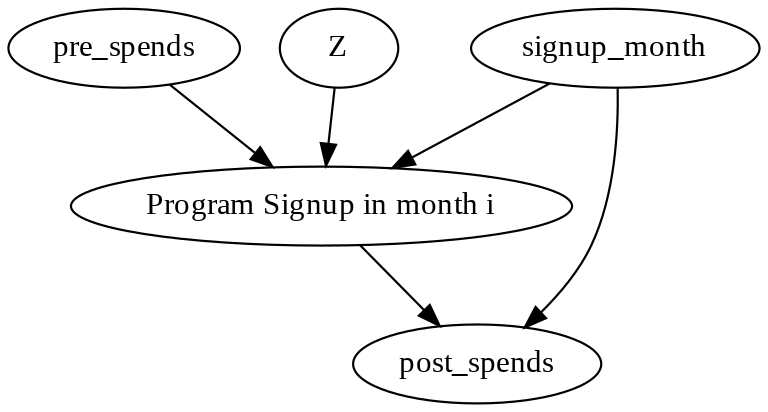

In [27]:
causal_graph = """digraph {
treatment[label="Program Signup in month i"];
pre_spends;
post_spends;
Z->treatment;
pre_spends -> treatment;
treatment->post_spends;
signup_month->post_spends;
signup_month->treatment;
}"""

model = dowhy.CausalModel(data=df_i_signupmonth,
                     graph=causal_graph.replace("\n", " "),
                     treatment="treatment",
                     outcome="post_spends")
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [48]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                             
────────────(Expectation(post_spends|signup_month))
d[treatment]                                       
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→post_spends then P(post_spends|treatment,signup_month,U) = P(post_spends|treatment,signup_month)

### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(post_spends, [pre_spends, Z])*Derivative([treatment], [
pre_spends, Z])**(-1))
Estimand assumption 1, As-if-random: If U→→post_spends then ¬(U →→{pre_spends,Z})
Estimand assumption 2, Exclusion: If we remove {pre_spends,Z}→{treatment}, then ¬({pre_spends,Z}→post_spends)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [49]:
### Estimand - backdoor 에 따르면 signup_month 만 통제(Condtioning) 하게 되면 Causal - Estimand 를 추정할 수 있을것입니다. 
# 위의 Backdoor 추정치를 활용하여서, 효과를 추정해봅시다. 
# 이때 사용한 방법은 Propensity Score Matching 을 사용했습니다. 
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.propensity_score_matching",
                                target_units="ate")
print(estimate)

propensity_score_matching


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                             
────────────(Expectation(post_spends|signup_month))
d[treatment]                                       
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→post_spends then P(post_spends|treatment,signup_month,U) = P(post_spends|treatment,signup_month)

## Realized estimand
b: post_spends~treatment+signup_month
Target units: ate

## Estimate
Mean value: 95.71657579284852



In [ ]:
# 위와 같이 평균 처치 효과를 알려줍니다. 
# 즉, i=3 개월에 리워드 프로그램에 등록한 고객의 총 지출에 대한 평균 효과입니다. 
# i 값을 변경한 후 분석을 다시 실행하여 다른 달에 가입한 고객에 대한 효과를 비슷한 방법으로 계산할 수 있습니다.